*First compiled on May 25, 2017.*

### Lineage tree for adult hematopoiesis in mouse [(Nestorowa *et al.*, 2016)](https://doi.org/10.1182/blood-2016-05-716480)

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 1                # increase for more output
sc.settings.set_dpi(60)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+16.g8ae527b.dirty on 2017-09-22 09:52.


In [2]:
cell_types = {
    'start_cells': '0Stem',  # stem cell / progenitor
    'C1': '1Ery',
    'C2': '2Mk',             # megakaryotic
    'C3' : '3',
    'C4': '4Baso',           # mast cell/basophil
    'C5': '5Neu',            # monocyte / granulocyte ?
    'C6': '6',
    'C7': '7Mo',             # granulocyte / monocyte ?
    'C8': '8Lymph',          # lymphoid
    'C9': '9',
    'C10': '10B'}            # B cells

def nestorowa16_raw():
    datadir = 'data/nestorowa16/data/'
    adata = sc.read(datadir + 'norm_counts_nestorowa_data.txt', cache=True)
    adata.smp_names = np.genfromtxt(datadir + 'cell_names_nestorowa_data.txt', dtype=str)
    adata.var_names = np.genfromtxt(datadir + 'gene_names_nestorowa_data.txt', dtype=str)
    exp_groups = np.genfromtxt(datadir + 'start_and_end_cells.txt', dtype=str)
    exp_groups = np.array([cell_types[n] if n in cell_types else n for n in exp_groups])                                                                                                                                       
    exp_groups[718] = 'no_gate'  # deal with one outlier in the C9 group
    adata.smp['exp_groups'] = exp_groups
    return adata

def nestorowa16():
    adata = nestorowa16_raw()    
    sc.pp.recipe_weinreb16(adata, svd_solver='arpack')
    adata.add['iroot'] = np.flatnonzero(adata.smp['exp_groups'] == '0Stem')[0]
    return adata

In [6]:
adata_raw = nestorowa16_raw()
sc.write('nestorowa16_raw', adata_raw)

reading ./write/data/nestorowa16/data/norm_counts_nestorowa_data.h5
writing ./write/nestorowa16_raw.h5


reading ./write/data/nestorowa16/data/norm_counts_nestorowa_data.h5


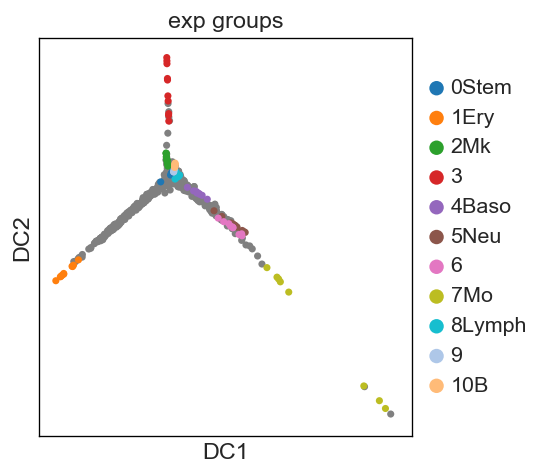

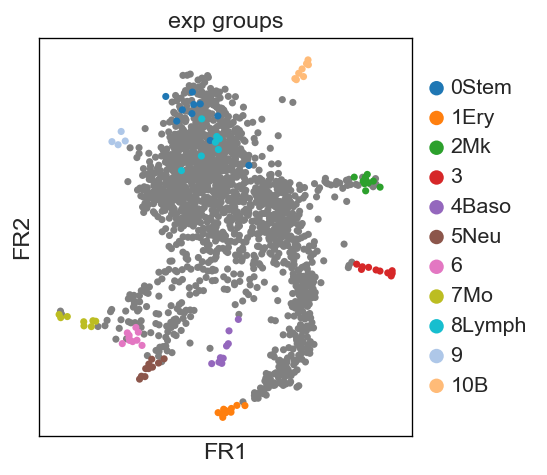

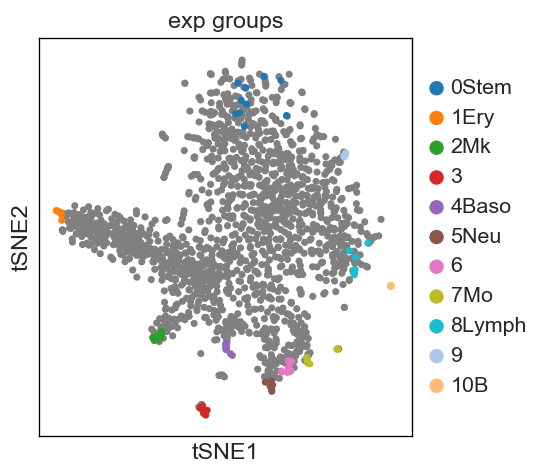

writing ./write/nestorowa16.h5


In [7]:
adata = nestorowa16()
sc.tl.diffmap(adata, n_neighbors=4)
ax = sc.pl.diffmap(adata, color='exp_groups')
sc.tl.draw_graph(adata, n_neighbors=4)
ax = sc.pl.draw_graph(adata, color='exp_groups')
sc.tl.tsne(adata)
ax = sc.pl.tsne(adata, color='exp_groups')
sc.write('nestorowa16', adata)

### Tree inference using graph abstraction

We use the same number of neighbors as for visualizing the data above and as in [*paul15*](../paul15).

In [5]:
adata = sc.read('nestorowa16')
sc.tl.aga(adata, n_neighbors=4, resolution=1.3, tree_detection='iterative_matching')
sc.write('nestorowa16', adata)

reading ./write/nestorowa16.h5
writing ./write/nestorowa16.h5


reading ./write/nestorowa16.h5


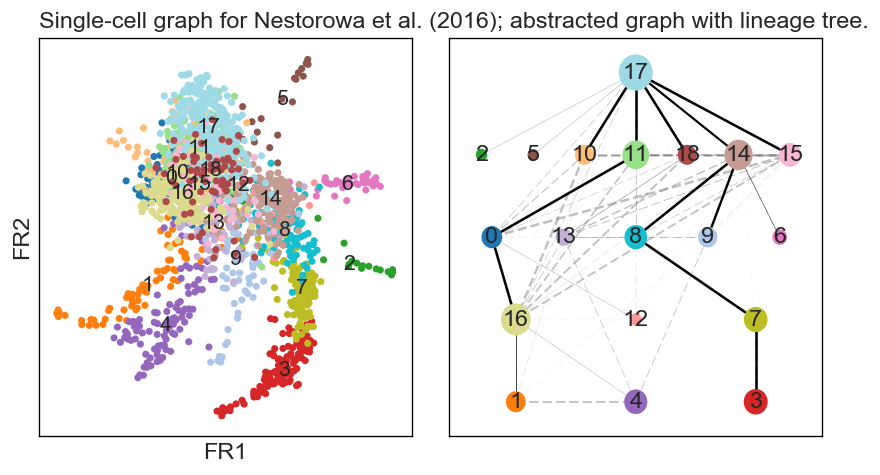

In [6]:
adata = sc.read('nestorowa16')
axs = sc.pl.aga(adata, title='', title_graph='', basis='draw_graph_fr',
                root=17, color='aga_groups', groups_graph='aga_groups', layout='eq_tree', show=False)
axs[0].set_title('Single-cell graph for Nestorowa et al. (2016); abstracted graph with lineage tree.', loc='left')
pl.savefig('./figures/aga.png')
pl.show()

reading ./write/nestorowa16.h5


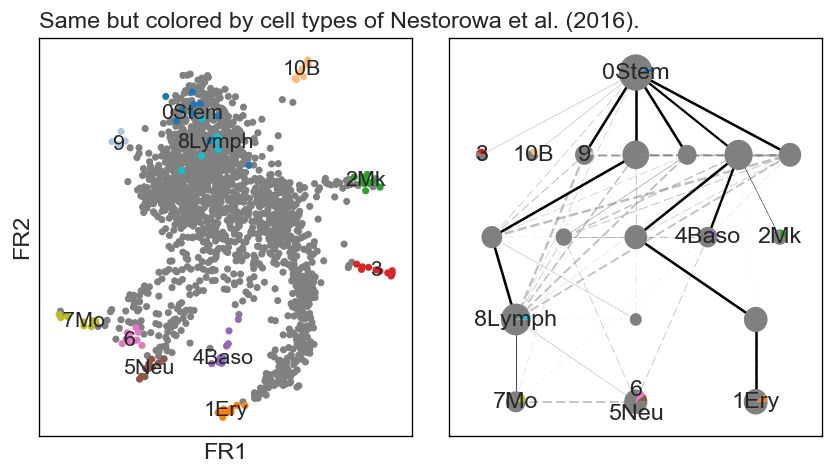

In [7]:
adata = sc.read('nestorowa16')
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='aga_groups', reference='exp_groups', normalization='prediction')
asso_colors = sc.utils.get_associated_colors_of_groups(sc.pl.palettes.vega_20, asso_matrix)
axs = sc.pl.aga(adata, title='', 
          color='exp_groups',
          title_graph='',
          basis='draw_graph_fr',
          root=17, color_graph=asso_colors, groups_graph=asso_names, layout='eq_tree', frameon=True, show=False)
axs[0].set_title('Same but colored by cell types of Nestorowa et al. (2016).', loc='left')
pl.savefig('./figures/aga_cell_types.png')
pl.show()

### Reconstruct dynamics for differentially expressed genes of leaf nodes

Some marker genes.

| cell type | marker |
| --- | --- |
| Erythroid | Gata1, Gypa, Hba-a2, Hba-a1 |
|Megakaryocyte | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|'3' population | Ltf, Retnlg |
|Basophils | Prss34, Ms4a2, Fcer1a, Siglecf |
|Monocyte | Irf8, Csf1r, Ctsg, Mpo |
|Neutrophils | Elane, Ctsg, Mpo, Gfi1 | 
|Lymphoid | Dntt, Il7r, Rag2 |
|B cells | Cd19, Vpreb2, Cd79a |

In [4]:
adata = sc.read('nestorowa16')
adata_all_genes = nestorowa16_raw()
sc.pp.recipe_zheng17(adata_all_genes, n_top_genes=4000)
adata_all_genes.smp['aga_groups'] = adata.smp['aga_groups']
adata_all_genes.smp['aga_pseudotime'] = adata.smp['aga_pseudotime']

reading ./write/nestorowa16.h5
reading ./write/data/nestorowa16/data/norm_counts_nestorowa_data.h5


In [5]:
gene_names = ['Gata2', 'Gata1', 'Hba-a2', 'Gfi1', 'Elane', 'Irf8', 'Csf1r']

reading ./write/nestorowa16.h5


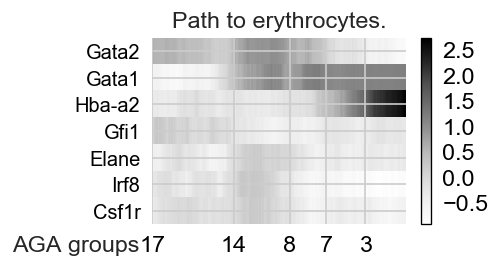

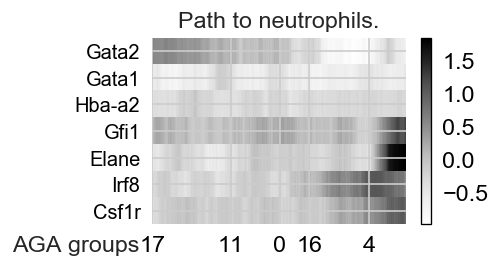

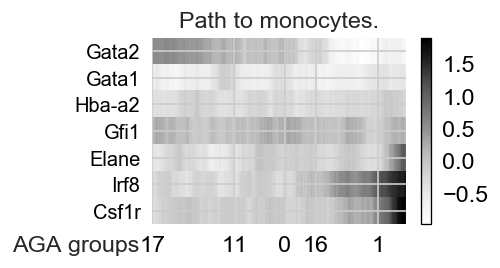

In [6]:
adata = sc.read('nestorowa16')
paths = [('erythrocytes', [17, 14, 8, 7, 3]),
         ('neutrophils', [17, 11, 0, 16, 4]),
         ('monocytes', [17, 11, 0, 16, 1])]
rcParams['figure.figsize'] = (4, 2.16)
rcParams['figure.subplot.top'] = 0.85
rcParams['figure.subplot.bottom'] = 0.13
for ipath, (descr, path) in enumerate(paths):
    ax = sc.pl.aga_path(adata_all_genes, left_margin=0.3,
                        nodes=path,
                        ytick_fontsize=12,
                        keys=gene_names,
                        n_avg=50,
                        title='Path to {}.'.format(descr),
                        normalize_to_zero_one=False, show=False)
    pl.savefig('./figures/aga_path_{}.png'.format(descr))
    pl.show()
sc.pl.reset_rcParams()